In [1]:
!pip install pandas==2.0.3 numpy==1.24.3 matplotlib==3.7.2 seaborn==0.12.2
!pip install pillow==10.0.0 scikit-learn==1.3.0 tqdm==4.66.4
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0

In [2]:
"""
EMOTIC Model Testing and Evaluation
This script tests trained BCE and Focal Loss models on the EMOTIC dataset.
"""

# -------------------------
# Imports
# -------------------------
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import (
    average_precision_score,
    f1_score,
)
from tqdm import tqdm

Using device: mps
Loading test data...
Test dataset size: 7279 samples
Loading models...
BCE model loaded successfully
Focal Loss model loaded successfully

Thresholds loaded successfully
BCE thresholds shape: (26,)
Focal thresholds shape: (26,)

Evaluating BCE Model...


Testing BCE Model: 100%|██████████| 228/228 [00:57<00:00,  3.94it/s]



Evaluating Focal Loss Model...


Testing Focal Loss Model: 100%|██████████| 228/228 [00:56<00:00,  4.07it/s]



EVALUATION RESULTS

--- BCE Model Results ---
Mean Average Precision (mAP): 0.2350
C-F1 (Label-based F1): 0.1744
O-F1 (Example-based F1): 0.3085

--- Focal Loss Model Results ---
Mean Average Precision (mAP): 0.1893
C-F1 (Label-based F1): 0.2276
O-F1 (Example-based F1): 0.2557

PER-CATEGORY RESULTS

Detailed Per-Category Metrics:
      Emotion  BCE_AP  BCE_F1  Focal_AP  Focal_F1
    Affection  0.2062  0.2046    0.2071    0.2697
        Anger  0.1460  0.1137    0.1360    0.2401
    Annoyance  0.5557  0.2407    0.5384    0.6399
 Anticipation  0.8421  0.6263    0.8229    0.8723
     Aversion  0.6691  0.3554    0.6916    0.6451
   Confidence  0.6854  0.4592    0.5427    0.6482
  Disapproval  0.3674  0.2047    0.3479    0.4567
Disconnection  0.6446  0.3413    0.5713    0.0000
 Disquietment  0.0718  0.0610    0.0611    0.1152
        Doubt  0.1149  0.0937    0.0846    0.1560
Embarrassment  0.1776  0.1138    0.1452    0.2536
   Engagement  0.2227  0.2317    0.1781    0.2666
       Esteem  0.

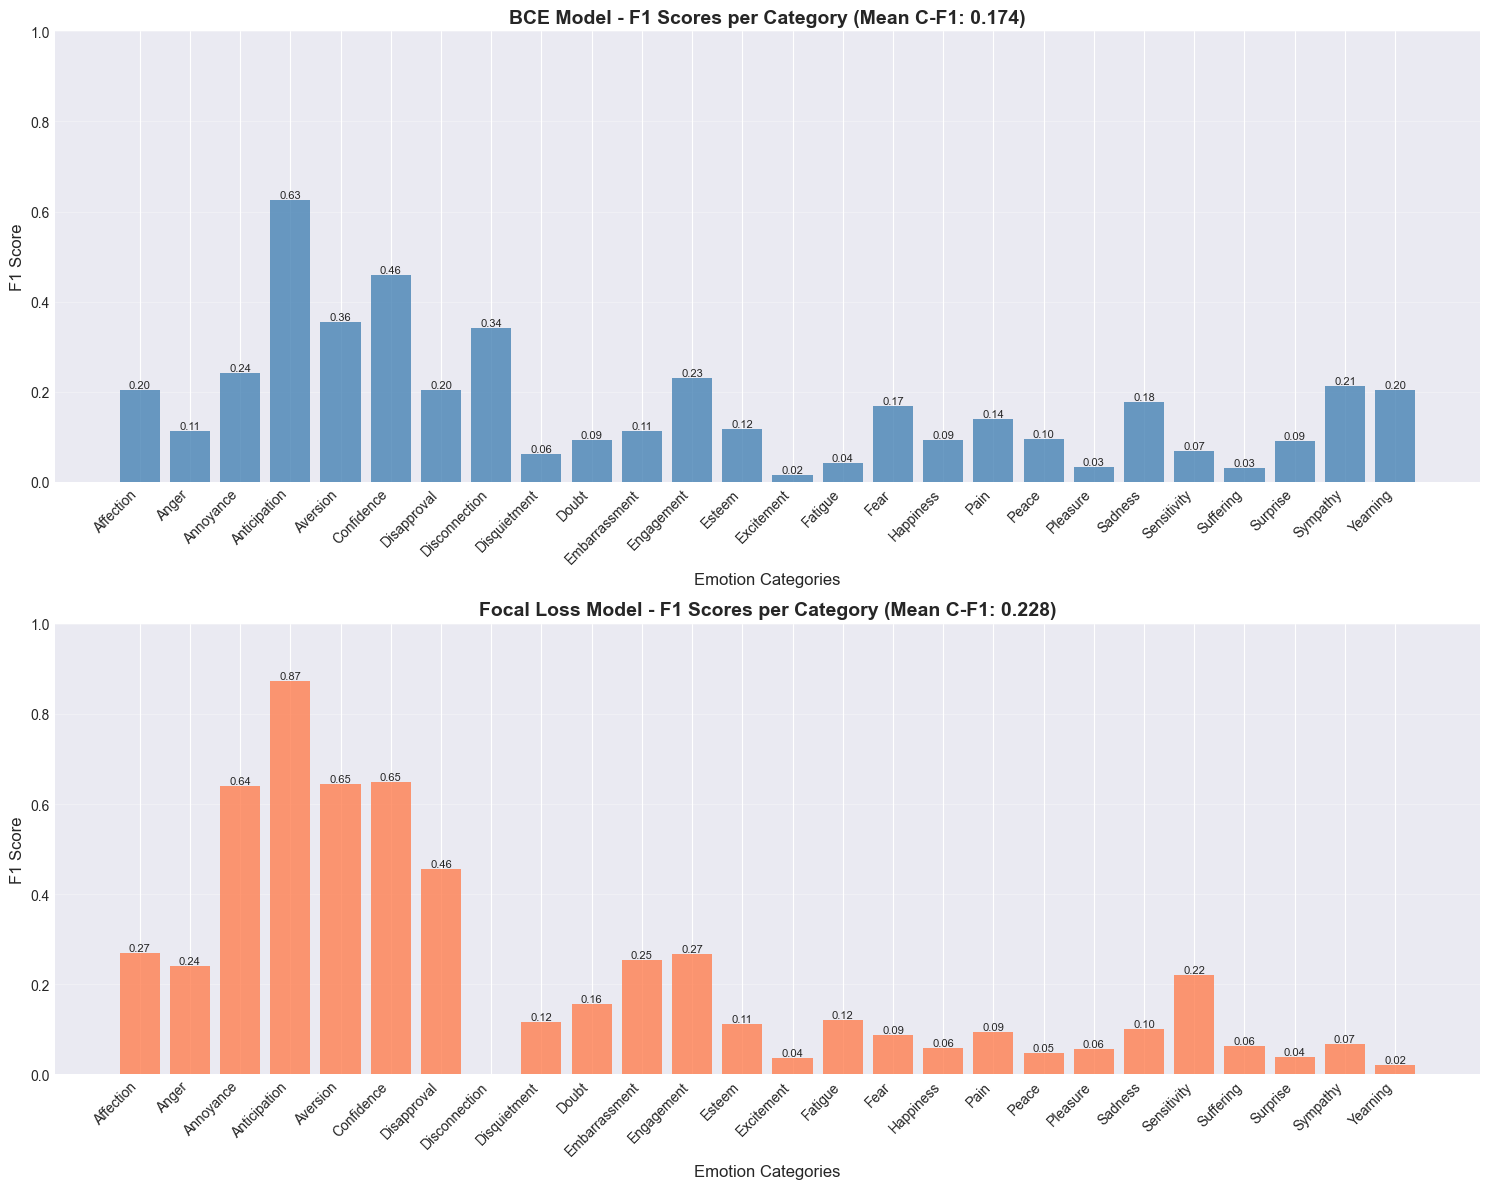

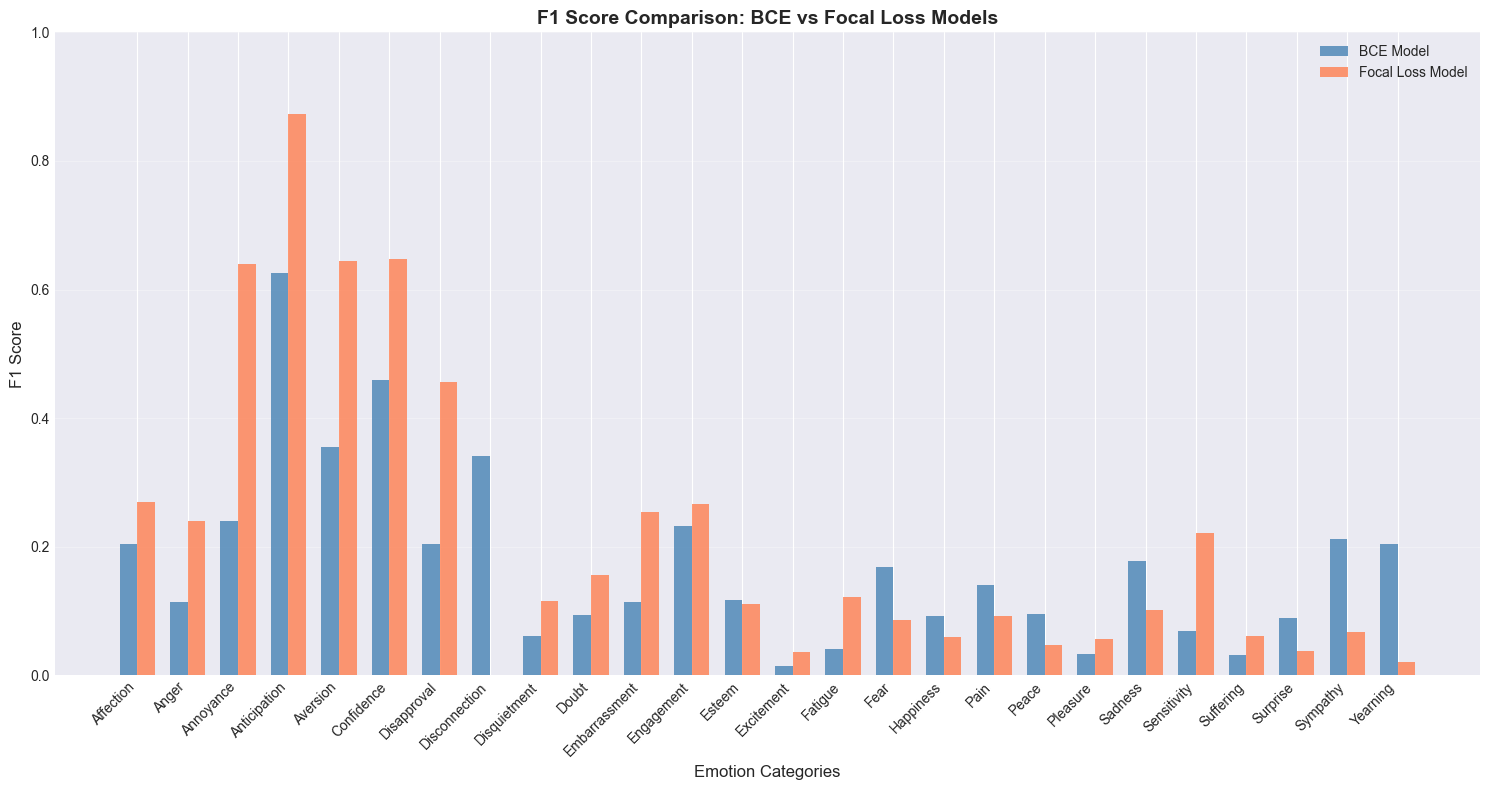


ADDITIONAL STATISTICS

Most improved category (Focal vs BCE):
  Annoyance: 0.3992 improvement

Least improved category (Focal vs BCE):
  Disconnection: -0.3413 degradation

----------------------------------------
Top 5 Best Performing Categories
----------------------------------------

BCE Model:
  Anticipation: 0.6263
  Confidence: 0.4592
  Aversion: 0.3554
  Disconnection: 0.3413
  Annoyance: 0.2407

Focal Loss Model:
  Anticipation: 0.8723
  Confidence: 0.6482
  Aversion: 0.6451
  Annoyance: 0.6399
  Disapproval: 0.4567

MODEL COMPARISON SUMMARY
✓ BCE model performs better on mAP by 0.0456
✓ Focal Loss model performs better on C-F1 by 0.0531
✓ BCE model performs better on O-F1 by 0.0528

----------------------------------------
Percentage Improvements (Focal vs BCE)
----------------------------------------
mAP: -19.42%
C-F1: +30.45%
O-F1: -17.10%


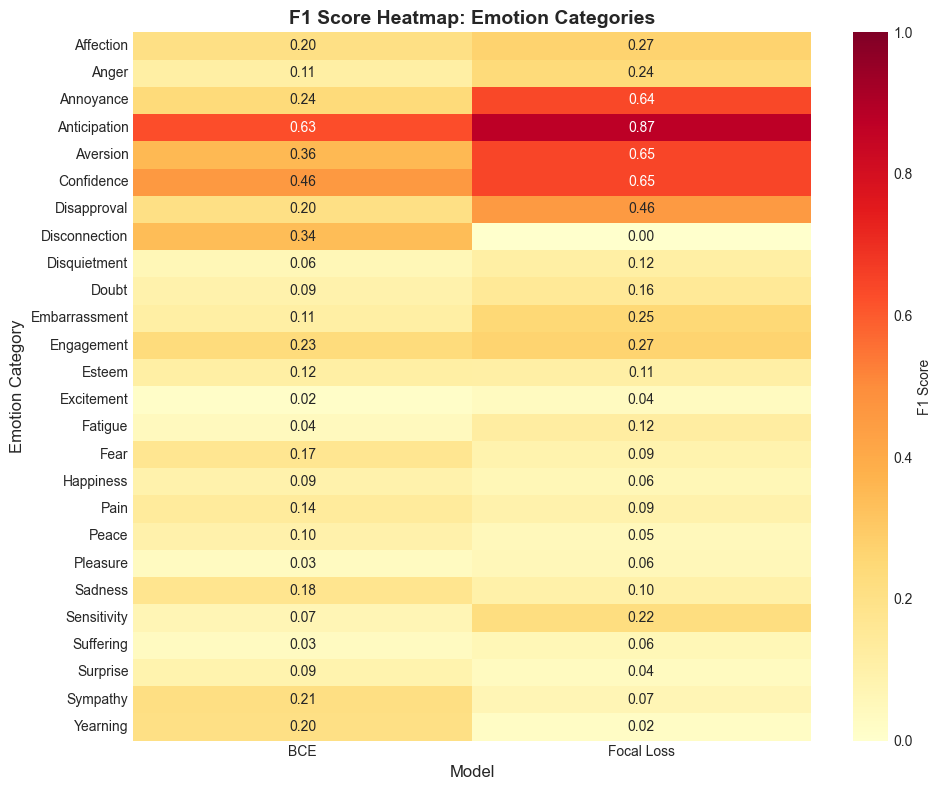


All visualizations have been saved!


In [3]:


# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -------------------------
# Device Configuration
# -------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# -------------------------
# Constants
# -------------------------
EMOTION_CATEGORIES = [
    'Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
    'Confidence', 'Disapproval', 'Disconnection', 'Disquietment', 'Doubt',
    'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue',
    'Fear', 'Happiness', 'Pain', 'Peace', 'Pleasure',
    'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy',
    'Yearning'
]

# -------------------------
# Dataset and Model Definitions
# -------------------------
def parse_annotations(csv_path, num_categories=26):
    df = pd.read_csv(csv_path)
    annotations = []
    category_columns = df.columns[9:39]  # adjust if your CSV layout differs

    for _, row in df.iterrows():
        categories = [int(idx) for idx, val in enumerate(row[category_columns]) if val == 1 and idx < num_categories]
        annotation = {
            'filename': row['Crop_name'],
            'categories': categories,
        }
        annotations.append(annotation)

    return annotations


class EMOTICDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None, num_categories=26):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.num_categories = num_categories

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        entry = self.annotations[idx]
        img_path = os.path.join(self.img_dir, entry['filename'])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")

        image = np.load(img_path)

        # Ensure image is RGB
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[-1] != 3:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        image_tensor = self.transform(image)
        categories = torch.zeros(self.num_categories, dtype=torch.float32)
        for category in entry['categories']:
            if 0 <= category < self.num_categories:
                categories[category] = 1.0

        return image_tensor, categories


class ResNet50EmotionModel(nn.Module):
    def __init__(self, num_classes=26, freeze=True):
        super(ResNet50EmotionModel, self).__init__()
        self.cnn = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        if freeze:
            for name, param in self.cnn.named_parameters():
                if "layer4" in name or "fc" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        self.cnn.fc = nn.Identity()
        self.fc_categories = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        categories = self.fc_categories(features)
        return categories

# -------------------------
# Evaluation Metrics
# -------------------------
def calculate_average_precision(y_true, y_scores):
    """Average Precision for each category."""
    ap_scores = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0:
            ap = average_precision_score(y_true[:, i], y_scores[:, i])
            ap_scores.append(ap)
        else:
            ap_scores.append(0.0)
    return np.array(ap_scores)


def calculate_label_based_f1(y_true, y_pred):
    """C-F1: F1 score per class, then average."""
    f1_scores = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0 or y_pred[:, i].sum() > 0:
            f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], average='binary', zero_division=0))
        else:
            f1_scores.append(0.0)
    return np.array(f1_scores)


def calculate_example_based_f1(y_true, y_pred):
    """O-F1: F1 score per sample, then average."""
    f1_scores = []
    for i in range(len(y_true)):
        if y_true[i].sum() > 0 or y_pred[i].sum() > 0:
            f1_scores.append(f1_score(y_true[i], y_pred[i], average='binary', zero_division=0))
        else:
            f1_scores.append(0.0)
    return np.mean(f1_scores)

# -------------------------
# Model Evaluation
# -------------------------
def evaluate_model(model, test_loader, thresholds, model_name, device):
    """Evaluate a single model and return metrics."""
    model.eval()
    all_targets, all_outputs = [], []

    print(f"\nEvaluating {model_name}...")
    with torch.no_grad():
        for images, categories in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            categories = categories.to(device)

            outputs = model(images)
            all_targets.extend(categories.cpu().numpy())
            all_outputs.extend(torch.sigmoid(outputs).cpu().numpy())

    all_targets = np.vstack(all_targets)
    all_outputs = np.vstack(all_outputs)

    # Apply thresholds to get predictions
    all_preds = np.zeros_like(all_outputs)
    for i in range(all_outputs.shape[1]):
        all_preds[:, i] = (all_outputs[:, i] > thresholds[i]).astype(int)

    # Calculate metrics
    results = {}
    ap_scores = calculate_average_precision(all_targets, all_outputs)
    results['ap_per_category'] = ap_scores
    results['mAP'] = np.mean(ap_scores[ap_scores > 0])  # ignore categories with no positives

    c_f1_scores = calculate_label_based_f1(all_targets, all_preds)
    results['c_f1_per_category'] = c_f1_scores
    results['c_f1_mean'] = np.mean(c_f1_scores[c_f1_scores > 0])

    results['o_f1'] = calculate_example_based_f1(all_targets, all_preds)

    results['predictions'] = all_preds
    results['targets'] = all_targets
    results['scores'] = all_outputs

    return results

# -------------------------
# Visualization
# -------------------------
def plot_f1_scores(bce_results, focal_results, emotion_categories):
    """Create bar plots comparing F1 scores for each emotion category."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    x = np.arange(len(emotion_categories))
    bars1 = ax1.bar(x, bce_results['c_f1_per_category'], color='steelblue', alpha=0.8)
    ax1.set_xlabel('Emotion Categories', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.set_title(f'BCE Model - F1 Scores per Category (Mean C-F1: {bce_results["c_f1_mean"]:.3f})', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(emotion_categories, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1])
    for bar in bars1:
        h = bar.get_height()
        if h > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., h, f'{h:.2f}', ha='center', va='bottom', fontsize=8)

    bars2 = ax2.bar(x, focal_results['c_f1_per_category'], color='coral', alpha=0.8)
    ax2.set_xlabel('Emotion Categories', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title(f'Focal Loss Model - F1 Scores per Category (Mean C-F1: {focal_results["c_f1_mean"]:.3f})', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(emotion_categories, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 1])
    for bar in bars2:
        h = bar.get_height()
        if h > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., h, f'{h:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('f1_scores_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 8))
    width = 0.35
    x = np.arange(len(emotion_categories))
    ax.bar(x - width/2, bce_results['c_f1_per_category'], width, label='BCE Model', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, focal_results['c_f1_per_category'], width, label='Focal Loss Model', color='coral', alpha=0.8)
    ax.set_xlabel('Emotion Categories', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('F1 Score Comparison: BCE vs Focal Loss Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(emotion_categories, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.savefig('f1_scores_direct_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    # Paths
    test_annotations_path = "archive/annots_arrs/annot_arrs_test.csv"
    img_dir = "archive/img_arrs"
    bce_model_path = "weighted_bce_resnet50_emotic.pth"
    focal_model_path = "focal_loss_resnet50_emotic.pth"
    bce_thresholds_path = "bce_dynamic_thresholds.npy"
    focal_thresholds_path = "focal_dynamic_thresholds.npy"

    # Hyperparameters
    batch_size = 32
    num_classes = 26

    # Transformations (same as validation in training)
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load test data
    print("Loading test data...")
    test_annotations = parse_annotations(test_annotations_path, num_categories=num_classes)
    test_dataset = EMOTICDataset(test_annotations, img_dir=img_dir,
                                 transform=test_transform, num_categories=num_classes)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Test dataset size: {len(test_dataset)} samples")

    # Load models
    print("Loading models...")
    bce_model = ResNet50EmotionModel(num_classes=num_classes).to(device)
    bce_model.load_state_dict(torch.load(bce_model_path, map_location=device))
    print("BCE model loaded successfully")

    focal_model = ResNet50EmotionModel(num_classes=num_classes).to(device)
    focal_model.load_state_dict(torch.load(focal_model_path, map_location=device))
    print("Focal Loss model loaded successfully")

    # Load thresholds
    bce_thresholds = np.load(bce_thresholds_path)
    focal_thresholds = np.load(focal_thresholds_path)
    print("\nThresholds loaded successfully")
    print(f"BCE thresholds shape: {bce_thresholds.shape}")
    print(f"Focal thresholds shape: {focal_thresholds.shape}")

    # Evaluate
    bce_results = evaluate_model(bce_model, test_loader, bce_thresholds, "BCE Model", device)
    focal_results = evaluate_model(focal_model, test_loader, focal_thresholds, "Focal Loss Model", device)

    # Display summary
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)

    print("\n--- BCE Model Results ---")
    print(f"Mean Average Precision (mAP): {bce_results['mAP']:.4f}")
    print(f"C-F1 (Label-based F1): {bce_results['c_f1_mean']:.4f}")
    print(f"O-F1 (Example-based F1): {bce_results['o_f1']:.4f}")

    print("\n--- Focal Loss Model Results ---")
    print(f"Mean Average Precision (mAP): {focal_results['mAP']:.4f}")
    print(f"C-F1 (Label-based F1): {focal_results['c_f1_mean']:.4f}")
    print(f"O-F1 (Example-based F1): {focal_results['o_f1']:.4f}")

    # Per-category results table
    print("\n" + "="*80)
    print("PER-CATEGORY RESULTS")
    print("="*80)

    results_df = pd.DataFrame({
        'Emotion': EMOTION_CATEGORIES,
        'BCE_AP': bce_results['ap_per_category'],
        'BCE_F1': bce_results['c_f1_per_category'],
        'Focal_AP': focal_results['ap_per_category'],
        'Focal_F1': focal_results['c_f1_per_category']
    })

    results_df['BCE_AP'] = results_df['BCE_AP'].round(4)
    results_df['BCE_F1'] = results_df['BCE_F1'].round(4)
    results_df['Focal_AP'] = results_df['Focal_AP'].round(4)
    results_df['Focal_F1'] = results_df['Focal_F1'].round(4)

    print("\nDetailed Per-Category Metrics:")
    print(results_df.to_string(index=False))

    results_df.to_csv('per_category_results.csv', index=False)
    print("\nPer-category results saved to 'per_category_results.csv'")

    # Visualizations
    print("\nGenerating visualizations...")
    plot_f1_scores(bce_results, focal_results, EMOTION_CATEGORIES)

    # Additional statistics
    print("\n" + "="*80)
    print("ADDITIONAL STATISTICS")
    print("="*80)

    improvement = results_df['Focal_F1'] - results_df['BCE_F1']
    best_improved = results_df.loc[improvement.idxmax()]
    worst_improved = results_df.loc[improvement.idxmin()]

    print(f"\nMost improved category (Focal vs BCE):")
    print(f"  {best_improved['Emotion']}: {improvement.max():.4f} improvement")

    print(f"\nLeast improved category (Focal vs BCE):")
    print(f"  {worst_improved['Emotion']}: {improvement.min():.4f} {'improvement' if improvement.min() >= 0 else 'degradation'}")

    print("\n" + "-"*40)
    print("Top 5 Best Performing Categories")
    print("-"*40)
    print("\nBCE Model:")
    top5_bce = results_df.nlargest(5, 'BCE_F1')[['Emotion', 'BCE_F1']]
    for _, row in top5_bce.iterrows():
        print(f"  {row['Emotion']}: {row['BCE_F1']:.4f}")

    print("\nFocal Loss Model:")
    top5_focal = results_df.nlargest(5, 'Focal_F1')[['Emotion', 'Focal_F1']]
    for _, row in top5_focal.iterrows():
        print(f"  {row['Emotion']}: {row['Focal_F1']:.4f}")

    # Model comparison summary
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)

    if focal_results['mAP'] > bce_results['mAP']:
        print(f"✓ Focal Loss model performs better on mAP by {(focal_results['mAP'] - bce_results['mAP']):.4f}")
    else:
        print(f"✓ BCE model performs better on mAP by {(bce_results['mAP'] - focal_results['mAP']):.4f}")

    if focal_results['c_f1_mean'] > bce_results['c_f1_mean']:
        print(f"✓ Focal Loss model performs better on C-F1 by {(focal_results['c_f1_mean'] - bce_results['c_f1_mean']):.4f}")
    else:
        print(f"✓ BCE model performs better on C-F1 by {(bce_results['c_f1_mean'] - focal_results['c_f1_mean']):.4f}")

    if focal_results['o_f1'] > bce_results['o_f1']:
        print(f"✓ Focal Loss model performs better on O-F1 by {(focal_results['o_f1'] - bce_results['o_f1']):.4f}")
    else:
        print(f"✓ BCE model performs better on O-F1 by {(bce_results['o_f1'] - focal_results['o_f1']):.4f}")

    print("\n" + "-"*40)
    print("Percentage Improvements (Focal vs BCE)")
    print("-"*40)
    if bce_results['mAP'] != 0:
        map_improvement = ((focal_results['mAP'] - bce_results['mAP']) / bce_results['mAP']) * 100
        print(f"mAP: {map_improvement:+.2f}%")
    if bce_results['c_f1_mean'] != 0:
        cf1_improvement = ((focal_results['c_f1_mean'] - bce_results['c_f1_mean']) / bce_results['c_f1_mean']) * 100
        print(f"C-F1: {cf1_improvement:+.2f}%")
    if bce_results['o_f1'] != 0:
        of1_improvement = ((focal_results['o_f1'] - bce_results['o_f1']) / bce_results['o_f1']) * 100
        print(f"O-F1: {of1_improvement:+.2f}%")

    # Heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap_data = pd.DataFrame({
        'BCE': bce_results['c_f1_per_category'],
        'Focal Loss': focal_results['c_f1_per_category']
    }, index=EMOTION_CATEGORIES)
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'F1 Score'}, vmin=0, vmax=1)
    ax.set_title('F1 Score Heatmap: Emotion Categories', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Emotion Category', fontsize=12)
    plt.tight_layout()
    plt.savefig('f1_scores_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nAll visualizations have been saved!")
